In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os
import sys
import math
import glob
import copy
import warnings
import subprocess

import sep
import photutils

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse as mpl_ellip
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)

from astropy import wcs
from astropy.io import fits
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = photutils.utils.random_cmap(ncolors=512)
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [2]:
# isophotal analysis comes from photutils

from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model

In [3]:
def display_single(img, pixel_scale=0.4,
                   xsize=8, ysize=8, ax=None,
                   stretch='arcsinh', scale='zscale', 
                   contrast=0.25, no_negative=False,
                   lower_percentile=1.0, upper_percentile=99.0,
                   cmap=IMG_CMAP, scale_bar=True,
                   scale_bar_length=10.0, scale_bar_fontsize=20,
                   scale_bar_y_offset=0.5
                   ):
    """
    Display a single image. 
    
    :param img: np 2-D array for image 
    
    :param xsize: int, default = 8
        Width of the image. 
    :param ysize: int, default = 8
        Height of the image. 
    """
    #---------------------------------------------------------------------------#
    if ax is None:
        fig = plt.figure(figsize=(xsize, ysize))
        ax1 = fig.add_subplot(111)
    else: 
        ax1 = ax
    #---------------------------------------------------------------------------#

    #---------------------------------------------------------------------------#
    # Stretch option
    if stretch.strip() is 'arcsinh':
        img_scale = np.arcsinh(img)
    elif stretch.strip() is 'log':
        if no_negative:
            img[img <= 0.0] = 1.0E-10
        img_scale = np.log(img)
    elif stretch.strip() is 'log10':
        if no_negative:
            img[img <= 0.0] = 1.0E-10
        img_scale = np.log10(img)
    elif stretch.strip() is 'linear':
        img_scale = img
    else: 
        raise Exception("# Wrong stretch option.")

    # Scale option
    if scale.strip() is 'zscale':
        zmin, zmax = ZScaleInterval(contrast=contrast).get_limits(img_scale)
    elif scale.strip() is 'percentile':
        zmin, zmax = AsymmetricPercentileInterval(
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile).get_limits(img_scale)

    ax1.imshow(img_scale, origin='lower', cmap=cmap,
               vmin=zmin, vmax=zmax)
    #---------------------------------------------------------------------------#

    #---------------------------------------------------------------------------#
    # Hide ticks and tick labels
    ax1.tick_params(labelbottom='off', labelleft='off', 
                    axis=u'both', which=u'both', length=0)    
    #---------------------------------------------------------------------------#

    #---------------------------------------------------------------------------#
    # Put scale bar on the image
    (img_size_x, img_size_y) = img.shape
    if scale_bar:
        scale_bar_x_0 = int(img_size_x * 0.95 - 
                            (scale_bar_length / pixel_scale))
        scale_bar_x_1 = int(img_size_x * 0.95)
        scale_bar_y = int(img_size_y * 0.10)
        scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
        scale_bar_text_y = (scale_bar_y * scale_bar_y_offset)
        scale_bar_text = r'$%d^{\prime\prime}$' % int(scale_bar_length)
        scale_bar_text_size = scale_bar_fontsize

        ax1.plot([scale_bar_x_0, scale_bar_x_1], 
                 [scale_bar_y, scale_bar_y], 
                 linewidth=3, c='w', alpha=1.0)
        ax1.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, 
                 fontsize=scale_bar_text_size,
                 horizontalalignment='center', 
                 color='w')
    #---------------------------------------------------------------------------#
    
    #---------------------------------------------------------------------------#
    if ax is None:
        return fig
    else: 
        return ax1

### Read in the image

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


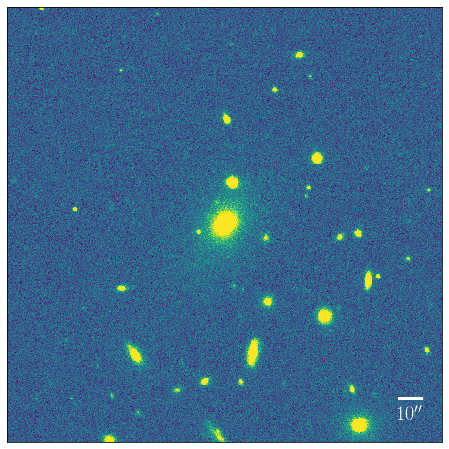

In [4]:
#fits_file = '/Users/song/Downloads/bcgs/bcg58out_hr.fits'
fits_file = '/Users/song/Downloads/bcgs/bcg10out_test_Mr_h.fits'

bcg_img = fits.open(fits_file)[0].data

_ = display_single(bcg_img, contrast=0.25)

### Try Undecimated Wavelet Transformation

* Need to install the `PyWavelets` package.

In [5]:
import pywt

In [62]:
# Pad the array, make sure it is power of 2, it defines the maximum level 
# swt2() can decompose
bcg_img_pad =np.pad(bcg_img, 6, 'reflect')

pywt.swt_max_level(bcg_img_pad.shape[0])

9

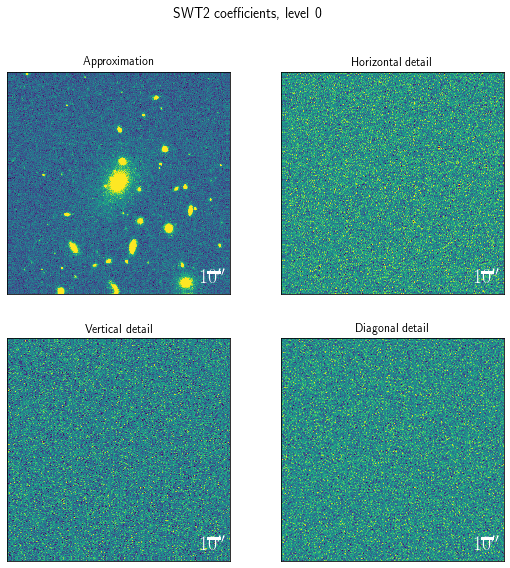

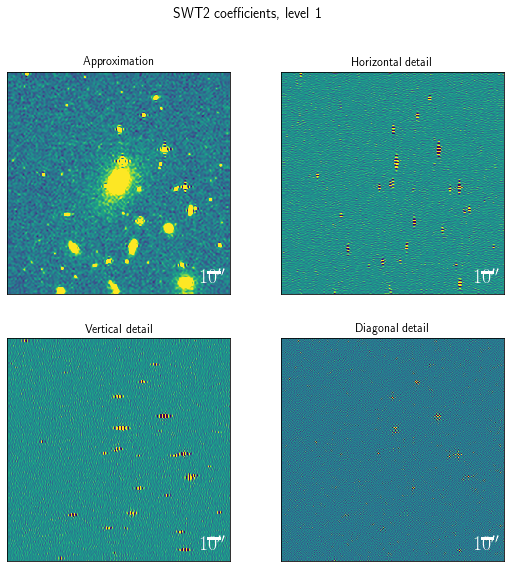

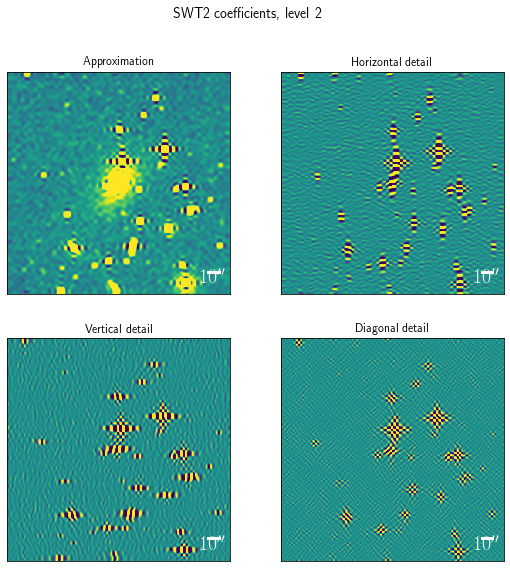

In [71]:
arr = np.arcsinh(bcg_img_pad)

level = 0
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

for LL, (LH, HL, HH) in pywt.swt2(arr, 'dmey', level=3, start_level=0):
    fig = plt.figure(figsize=(9, 9))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax = display_single(a, ax=ax)
        ax.set_title(titles[i], fontsize=12)

    fig.suptitle("SWT2 coefficients, level %s" % level, fontsize=14)
    level += 1

### SExtractor analysis

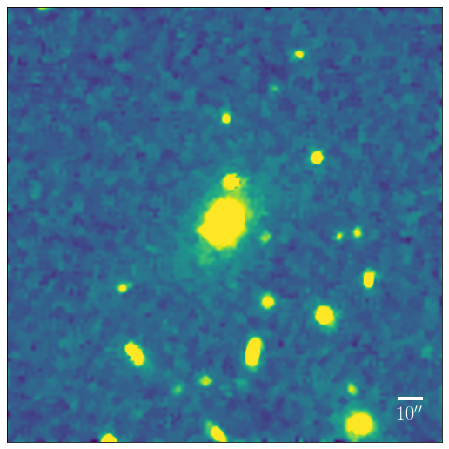

In [46]:
# High-resolution "backgroud", basically a low frequency version of the image

bkg_highres = sep.Background(bcg_img.byteswap().newbyteorder(), 
                             bw=4, bh=4, 
                             fw=2, fh=2)

_ = display_single(bkg_highres.back())

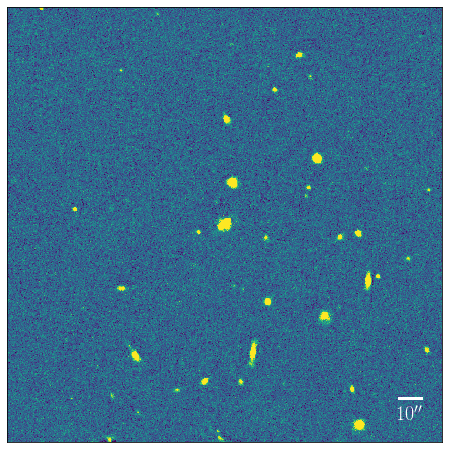

In [47]:
# Subtract this background, you have the high frequency part of the image

bcg_highfreq = bcg_img - bkg_highres.back()

_ = display_single(bcg_highfreq)

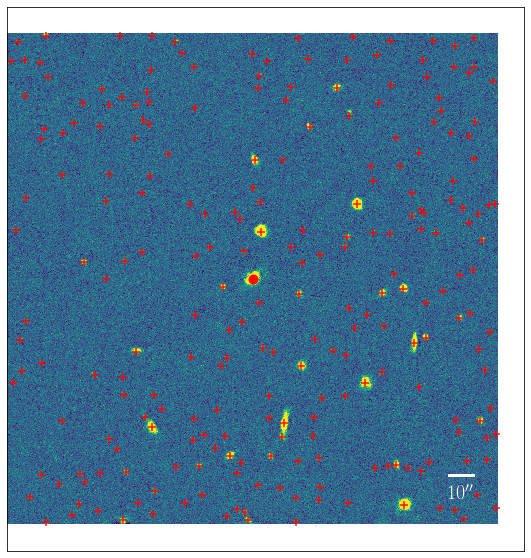

In [48]:
# Now try to detect objects on this map and do photometry using SExtractor algorithm

# Because there is no error image, the threshold does not make much sense
# And aggressive deblending should be used. 
obj_hot, seg_hot = sep.extract(bcg_highfreq, 
                               1.0, minarea=2, 
                               err=bkg_highres.rms(),
                               deblend_nthresh=64, deblend_cont=0.0001,
                               clean=True, clean_param=1.0,
                               segmentation_map=True)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)

_ = display_single(bcg_highfreq, ax=ax1)

ax1.scatter(obj_hot['x'], obj_hot['y'], c='r', marker='+', alpha=0.9, s=70)

# As you can see here, all the three "cores" are identified in this figure 

mask_cores = ((obj_hot['x'] > 240) & (obj_hot['x'] < 270) &
              (obj_hot['y'] > 240) & (obj_hot['y'] < 270))

ax1.scatter(obj_hot['x'][mask_cores], obj_hot['y'][mask_cores], 
            c='r', marker='o', facecolor='__none__', 
            alpha=0.9, s=80)

Text(0,0.5,'$\\log (\\rm Flux)$')

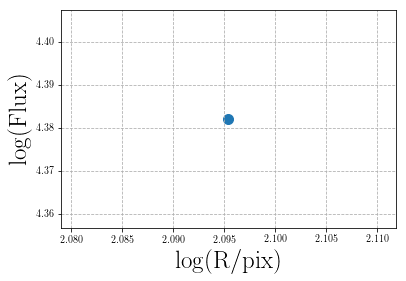

In [49]:
bcg_cores = obj_hot[mask_cores]

# Now you can get, for example, the flux and size of each cores.
# Of course, here the flux is the "additional flux" on top of a smooth component, so could
# depend on the smooth, low-frequency component

# And, not everything detected are true "cores", so you should masked out known SDSS galaxies before this. 

plt.scatter(np.log10(bcg_cores['cflux']), bcg_cores['a'], s=100)
plt.grid(linestyle='--')
plt.xlabel(r'$\log (\rm R/pix)$', fontsize=25)
plt.ylabel(r'$\log (\rm Flux)$', fontsize=25)

### Try unsharped mask

* Subtract the image with a convolved one, the convolution kernel should be similar to the seeing size
* Also, using RMS map in the source detection can help find faint object better

-0.000934119627345 0.0225521121174


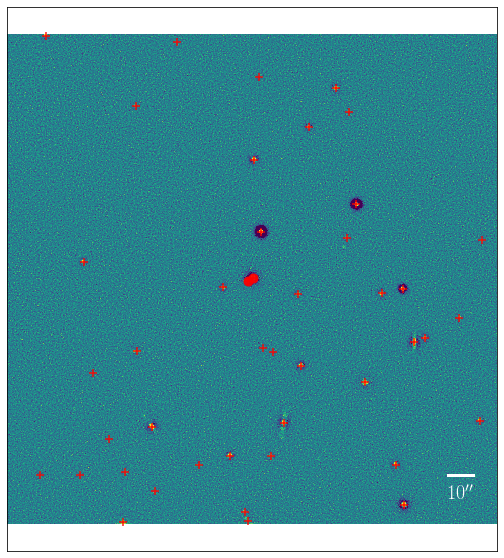

In [51]:
bcg_conv = convolve(bcg_img, Gaussian2DKernel(1.5))

bcg_diff = bcg_img - bcg_conv

bkg_diff = sep.Background(bcg_diff, bw=20, bh=20, fw=4, fh=4)
print(bkg_diff.globalback, bkg_diff.globalrms)

obj_diff, seg_diff = sep.extract(bcg_diff, 
                                 3.0, err=bkg_conv.rms(), minarea=2, 
                                 deblend_nthresh=64, deblend_cont=0.0001,
                                 clean=True, clean_param=1.0,
                                 segmentation_map=True)


fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)

_ = display_single(bcg_diff, ax=ax1)

ax1.scatter(obj_diff['x'], obj_diff['y'], c='r', marker='+', alpha=0.9, s=70)

# As you can see here, all the three "cores" are identified in this figure 

mask_cores = ((obj_diff['x'] > 240) & (obj_diff['x'] < 270) &
              (obj_diff['y'] > 240) & (obj_diff['y'] < 270))

ax1.scatter(obj_diff['x'][mask_cores], obj_diff['y'][mask_cores], 
            c='r', marker='o', facecolor='__none__', 
            alpha=0.9, s=80)

Text(0,0.5,'$\\log (\\rm Flux)$')

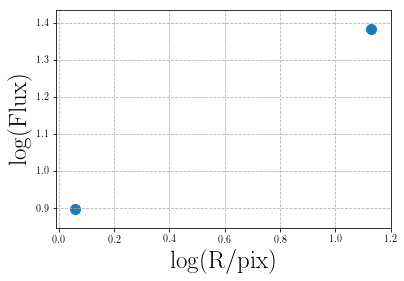

In [52]:
bcg_cores = obj_diff[mask_cores]

# Now you can get, for example, the flux and size of each cores.
# Of course, here the flux is the "additional flux" on top of a smooth component, so could
# depend on the smooth, low-frequency component

# And, not everything detected are true "cores", so you should masked out known SDSS galaxies before this. 

plt.scatter(np.log10(bcg_cores['cflux']), bcg_cores['a'], s=100)
plt.grid(linestyle='--')
plt.xlabel(r'$\log (\rm R/pix)$', fontsize=25)
plt.ylabel(r'$\log (\rm Flux)$', fontsize=25)

### Isophotal analysis

* More details can be found here: http://photutils.readthedocs.io/en/stable/isophote.html

In [34]:
# For example, here we use the coordinates of the brightest core as the "center of the galaxy"

core_bright = bcg_cores[np.argmax(bcg_cores['cflux'])]

xcen, ycen = core_bright['x'], core_bright['y']

# Initial guess of the geometry
geometry = EllipseGeometry(x0=xcen, y0=ycen, sma=10, eps=0.1,
                           pa=(10. * np.pi /180.))

# Feed the image and the initial guesses of geometry to Ellipse
ellipse = Ellipse(bcg_img, geometry)

# Fit elliptical isophotes to it 
bcg_isos = ellipse.fit_image(minsma=0.0, maxsma=60.0, step=0.08,
                             sma0=5.0, sclip=3.0, nclip=2)

print(bcg_isos.to_table())

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0    4.504991385011739 ...     0         0
0.5366375957689257    4.373191500542413 ...    10         0
0.5795686034304398    4.357708585612638 ...    10         0
 0.625934091704875    4.341327854508726 ...    10         0
0.6760088190412651    4.297459852070926 ...    10         0
0.7300895245645663    4.228980832392393 ...    10         0
0.7884966865297317    4.134570889983321 ...    50         2
0.8515764214521103    4.083488841937068 ...    50         2
0.9197025351682793    4.033689142809564 ...    10         0
0.9932787379817417   3.9876911673544475 ...    10         0
               ...                  ... ...   ...       ...
 29.35731822796351 0.054069287996734196 ...     0         4
31.705903686200593  0.04657332588539067 ...     0         4
 34.24237598109664   0.0395286179103183 

Text(0,0.5,'$\\mathrm{Fluxe}$')

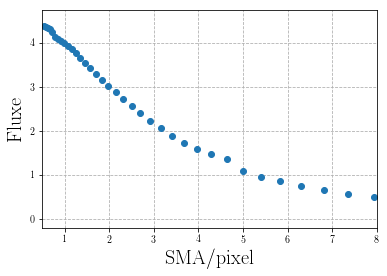

In [19]:
# Here is the surface intensity profiles

plt.errorbar(bcg_isos.sma, bcg_isos.intens, yerr=bcg_isos.int_err, fmt='o')

plt.grid(linestyle='--')
plt.xlim(0.5, 8.0)
plt.xlabel(r'$\mathrm{SMA/pixel}$', fontsize=20)
plt.ylabel(r'$\mathrm{Fluxe}$', fontsize=20)

Text(0,0.5,'$\\mathrm{X0/pixel}$')

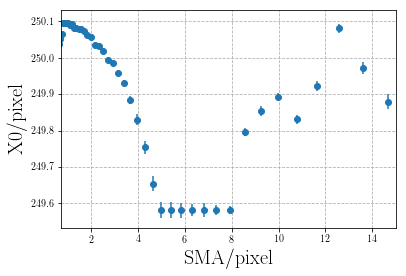

In [20]:
# Radial changes of central coordinates in X

# If there is no second core, no distortion, no asymmetry, (or contamination of nearby galaxy), 
# the centroids should not change

plt.errorbar(bcg_isos.sma, bcg_isos.x0, yerr=bcg_isos.x0_err, fmt='o')

plt.grid(linestyle='--')
plt.xlim(0.7, 15.0)
plt.xlabel(r'$\mathrm{SMA/pixel}$', fontsize=20)
plt.ylabel(r'$\mathrm{X0/pixel}$', fontsize=20)

Text(0,0.5,'$\\mathrm{Y0/pixel}$')

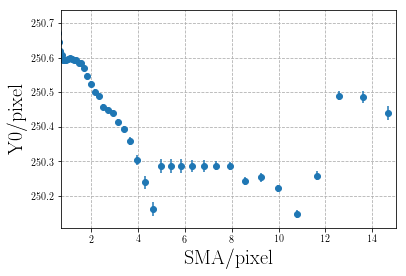

In [21]:
# Radial changes of central coordinates in Y
plt.errorbar(bcg_isos.sma, bcg_isos.y0, yerr=bcg_isos.y0_err, fmt='o')

plt.grid(linestyle='--')
plt.xlim(0.7, 15.0)
plt.xlabel(r'$\mathrm{SMA/pixel}$', fontsize=20)
plt.ylabel(r'$\mathrm{Y0/pixel}$', fontsize=20)

Text(0,0.5,'$\\mathrm{Ellipticity}$')

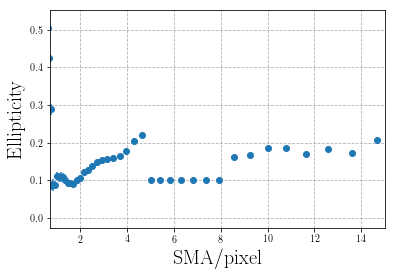

In [22]:
# You should also find some features on the radial changes of ellipticity and position angles

plt.errorbar(bcg_isos.sma, bcg_isos.eps, yerr=bcg_isos.ellip_err, fmt='o')

plt.grid(linestyle='--')
plt.xlim(0.7, 15.0)
plt.xlabel(r'$\mathrm{SMA/pixel}$', fontsize=20)
plt.ylabel(r'$\mathrm{Ellipticity}$', fontsize=20)

Text(0,0.5,'$\\mathrm{Position\\ Angle}$')

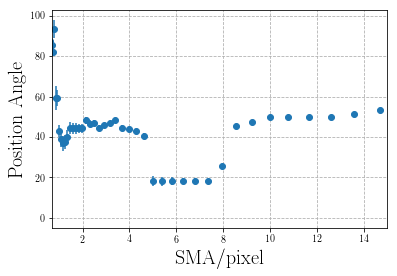

In [23]:
plt.errorbar(bcg_isos.sma, bcg_isos.pa * 180.0 / np.pi, 
             yerr=bcg_isos.pa_err * 180.0 / np.pi, fmt='o')

plt.grid(linestyle='--')
plt.xlim(0.7, 15.0)
plt.xlabel(r'$\mathrm{SMA/pixel}$', fontsize=20)
plt.ylabel(r'$\mathrm{Position\ Angle}$', fontsize=20)

* All these above figures show that the weigthed center of the isophote and the shape of the isophotes show dramatic changes 
  starting from the 5-10 pixels, which is when the flux from other cores kicks in
 
* You can also use the high-order Fourier amplitudes to show this. For example, in the figure below, guess who cause thoes two 
  peaks on the `a_3` and `b_3` profiles.

Text(0,0.5,'$\\mathrm{Ellipticity}$')

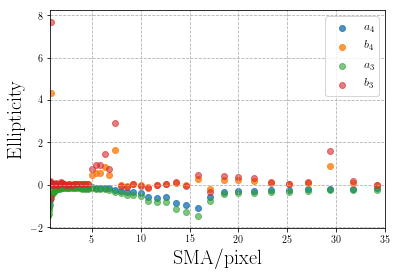

In [24]:
plt.scatter(bcg_isos.sma, bcg_isos.a4, label=r'$a_4$', alpha=0.8)
plt.scatter(bcg_isos.sma, bcg_isos.b4, label=r'$b_4$', alpha=0.8)
plt.scatter(bcg_isos.sma, bcg_isos.a3, label=r'$a_3$', alpha=0.6)
plt.scatter(bcg_isos.sma, bcg_isos.b3, label=r'$b_3$', alpha=0.6)

plt.legend(loc='best', fontsize=12)

plt.grid(linestyle='--')
plt.xlim(0.7, 35.0)
plt.xlabel(r'$\mathrm{SMA/pixel}$', fontsize=20)
plt.ylabel(r'$\mathrm{Ellipticity}$', fontsize=20)

* You can also build a smooth model for the core and subtract it out, on the residual image, you should be 
  able to perform photometry for the other cores 

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


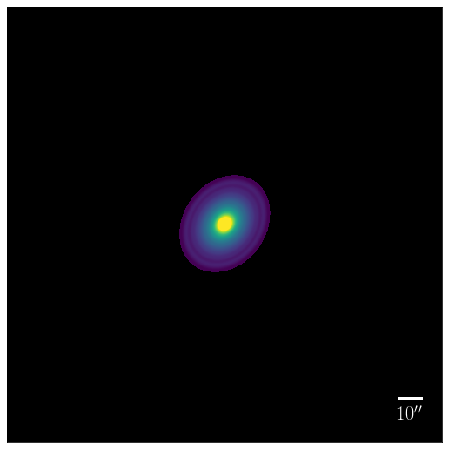

In [25]:
bcg_model = build_ellipse_model(bcg_img.shape, bcg_isos)

_ = display_single(np.log10(bcg_model), contrast=0.25)

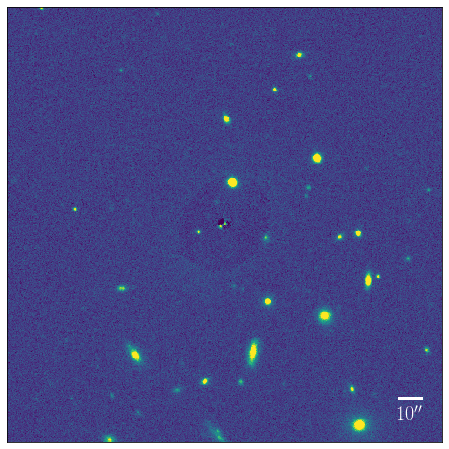

In [26]:
bcg_residual = bcg_img - bcg_model

_ = display_single(np.arcsinh(bcg_residual), contrast=0.1)

* In the above case, I use less aggressive sigma clipping to make sure the impacts of other cores can be noted. 

* If you want to subtract a more smooth model, you can use more aggressive sigma-clipping, and smaller step size

In [60]:
# For example, here I fit the profiles for three cores separately

# Of course, the fits on fainter cores will be more difficult, due to the stronger impact of brighter core

#core_1 = bcg_cores[0]
core_2 = bcg_cores[1]
#core_3 = bcg_cores[2]

#x1, y1 = core_1['x'], core_1['y']
x2, y2 = core_2['x'], core_2['y']
#x3, y3 = core_3['x'], core_3['y']

# Initial guess of the geometry
#geo1 = EllipseGeometry(x0=x1, y0=y1, sma=4, eps=0.05, pa=(10. * np.pi /180.))
geo2 = EllipseGeometry(x0=x2, y0=y2, sma=2, eps=0.05, pa=(10. * np.pi /180.))
#geo3 = EllipseGeometry(x0=x3, y0=y3, sma=4, eps=0.05, pa=(10. * np.pi /180.))

# Feed the image and the initial guesses of geometry to Ellipse
#ellipse1 = Ellipse(bcg_img, geo1)
ellipse2 = Ellipse(bcg_img, geo2)
#ellipse3 = Ellipse(bcg_img, geo3)

# Fit elliptical isophotes to it 
# Brightest core
#iso_core1 = ellipse1.fit_image(minsma=0.0, maxsma=60.0, step=0.05,
#                               sma0=2.0, sclip=2.0, nclip=3)
# The faintest core in the middle
iso_core2 = ellipse2.fit_image(minsma=0.0, maxsma=60.0, step=0.05,
                               sma0=2.0, sclip=2.0, nclip=3)
# The fainter core 
#iso_core3 = ellipse3.fit_image(minsma=0.0, maxsma=60.0, step=0.05,
#                               sma0=1.5, sclip=2.0, nclip=3)

#mod_core1 = build_ellipse_model(bcg_img.shape, iso_core1)
mod_core2 = build_ellipse_model(bcg_img.shape, iso_core2)
#mod_core3 = build_ellipse_model(bcg_img.shape, iso_core3)

#res_core1 = bcg_img - mod_core1
res_core2 = bcg_img - mod_core2
#res_core3 = bcg_img - mod_core3

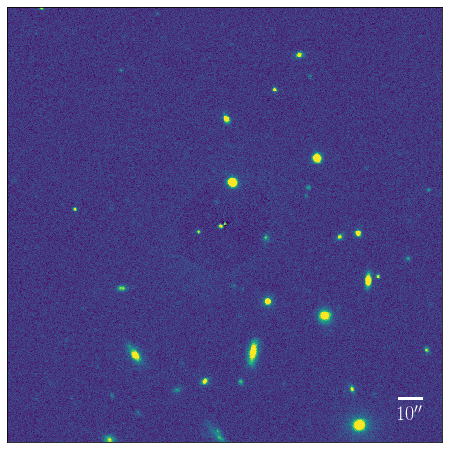

In [61]:
_ = display_single(res_core2, contrast=0.1)

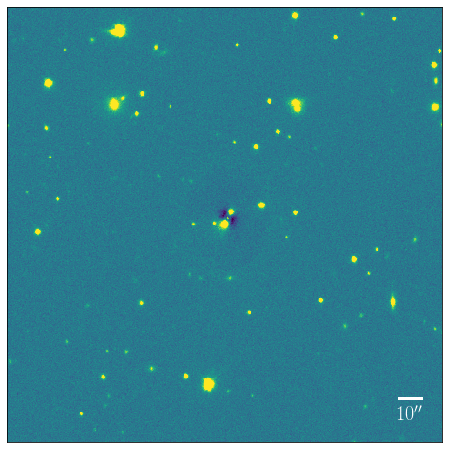

In [154]:
_ = display_single(res_core1, contrast=0.1)

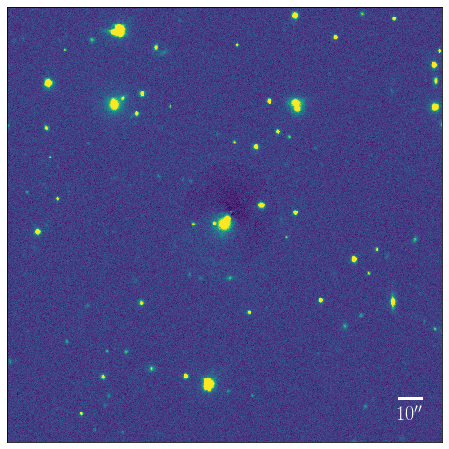

In [155]:
_ = display_single(res_core3, contrast=0.1)

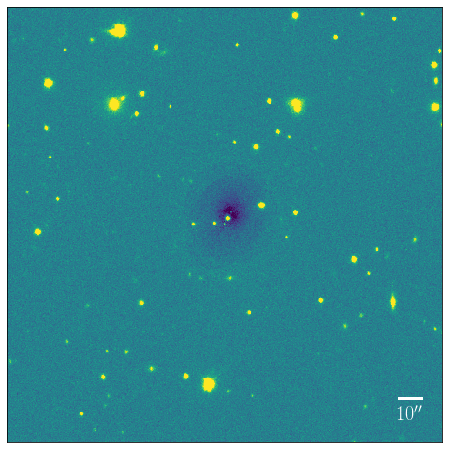

In [157]:
# Although it is over-subtracted, the fainest core on this residual image becomes more clear to see.

_ = display_single(bcg_img - mod_core1 - mod_core3, 
                   contrast=0.1)